In [2]:
from climada.hazard.base import Hazard
from climada.hazard.low_flow import LowFlow
from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import fiona
import datetime
import geopandas as gpd
from climada.util.coordinates import dist_to_coast

2020-06-25 15:40:01,521 - climada - DEBUG - Loading default config file: /home/zelie/Python_projects/climada_python/climada/conf/defaults.conf


In [14]:
lowflow = LowFlow()
lowflow.read_hdf5('hazards/computed_hazard_h08_gfdl-esm2m.h5')
#lowflow.read_hdf5('hazards/computed_hazard_lpjml_miroc5.h5')

2020-06-25 15:41:15,297 - climada.hazard.base - INFO - Reading hazards/computed_hazard_h08_gfdl-esm2m.h5


/home/zelie/Python_projects/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


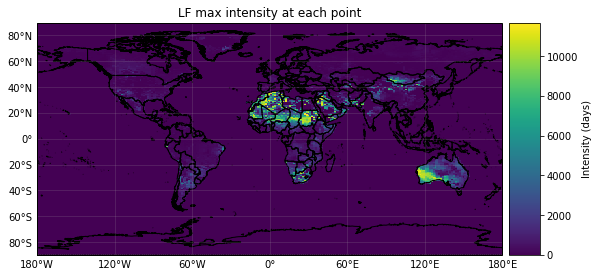

In [165]:
lowflow.plot_intensity(0)

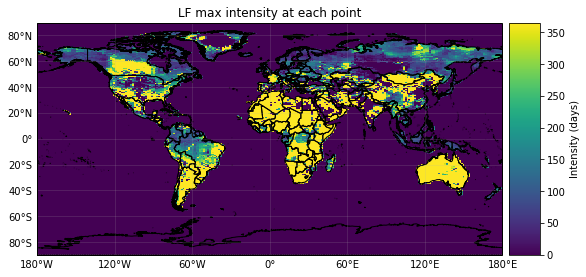

In [65]:
lowflow.plot_intensity(0,vmax=365)

In [8]:
wri_power_plants_path = '/home/zelie/Python_projects/low_flow/data/exposure/global_power_plant_database.csv'


def load_exposure(bbox=[-180, -90, 180, 90], exp_path=wri_power_plants_path, primary_fuel='Nuclear'):
    """load exposure data from CSV
    Here, we use WRI power plant data from
    https://www.wri.org/publication/global-power-plant-database"""
    exp_df = pd.read_csv(exp_path)
    if primary_fuel:
        exp_df = exp_df[exp_df.primary_fuel==primary_fuel]
    # europe:
    exp_df = exp_df[exp_df.longitude>bbox[0]]
    exp_df = exp_df[exp_df.longitude<bbox[2]]
    exp_df = exp_df[exp_df.latitude>bbox[1]]
    exp_df = exp_df[exp_df.latitude<bbox[3]]
    exp_df['gen_mean']=exp_df[["generation_gwh_2013", "generation_gwh_2014", "generation_gwh_2015", "generation_gwh_2016", "generation_gwh_2017"]].mean(axis=1)
    exp_df['value']=exp_df[["gen_mean", "estimated_generation_gwh"]].mean(axis=1)
    # exp_df['value'] = exp_df.capacity_mw # provide value in MegaWatt
    
    #exp_df['latitude'] = 
    #exp_df['longitude'] = 
    exp_df['if_'] = 1
    exp_df['if_LF'] = 1
    # exp_df = exp_df.drop(columns=['country', 'name', 'gppd_idnr',
    #    'latitude', 'longitude', 'primary_fuel', 'owner', 'source', 'url',
    #    'geolocation_source', 'wepp_id', 'year_of_capacity_data',
    #    'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
    #    'generation_gwh_2016', 'generation_gwh_2017',
    #    'estimated_generation_gwh', 'value', 'value_unit', 'if_TC', 'geometry'])
    

    # Generate Exposures from exposure-DataFranme
    exp_df = Exposures(exp_df)
    exp_df.value_unit = 'GWh'
    exp_df.ref_year = 2005
    exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
    print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
    exp_df.check() # puts metadata that has not been assigned
    return exp_df

In [9]:
nuclear_exp = load_exposure(primary_fuel='Nuclear')
coal_exp = load_exposure(primary_fuel='Coal')
gas_exp = load_exposure(primary_fuel='Gas')
hydro_exp = load_exposure(primary_fuel='Hydro')

2020-06-25 15:40:55,379 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-06-25 15:40:55,387 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-06-25 15:40:55,388 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-06-25 15:40:55,388 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-06-25 15:40:55,389 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-06-25 15:40:55,389 - climada.entity.exposures.base - INFO - centr_ not set.
2020-06-25 15:40:55,390 - climada.entity.exposures.base - INFO - deductible not set.
2020-06-25 15:40:55,390 - climada.entity.exposures.base - INFO - cover not set.
2020-06-25 15:40:55,391 - climada.entity.exposures.base - INFO - category_id not set.
2020-06-25 15:40:55,391 - climada.entity.exposures.base - INFO - region_id not set.
2020-06-25 15:40:55,534 - cl

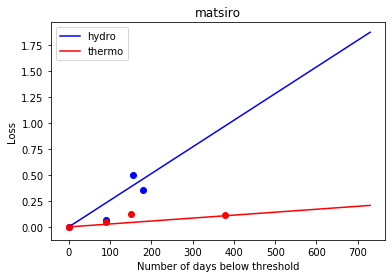

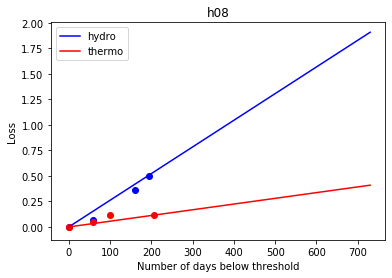

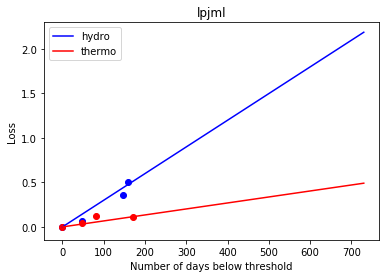

In [4]:
IF_data = pd.read_csv('IF_data2.csv')
hydro = IF_data[IF_data['Focus']=='Hydro']
thermo = IF_data[IF_data['Focus']!='Hydro']


col = {'thermo':'Red', 'hydro':'blue'}

data = {'thermo':thermo,'hydro':hydro}
if_slopes = {}

for h_model in ['matsiro','h08','lpjml']:
    fig, ax = plt.subplots()
    if_slopes[h_model] = {}
    for technology in ['hydro','thermo']:
        n = [0]+list(data[technology][h_model])
        d = [0]+list(data[technology]['loss'])

        x0 = np.linspace(0,365*2,100)
        s = np.polyfit(n,d,1)[0]
        if_slopes[h_model][technology] = s
        ax.plot(x0,s*x0,color = col[technology],label=technology)
        ax.scatter(n,d,color = col[technology])
        ax.set_xlabel('Number of days below threshold')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.set_title(" ".join([h_model]))
        

In [12]:
def init_IFS(s):
    """define impact function imp_fun and return impact function set (IFS)"""
    x0 = np.linspace(0,365,100)
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'LF'
    imp_fun.id = 1
    imp_fun.name = 'Low flow business interruption'
    imp_fun.intensity_unit = 'days'
    imp_fun.intensity = x0
    imp_fun.mdd = s*x0
 # loss to annual operation
    imp_fun.paa = imp_fun.intensity * 0 + 1
    # imp_fun.paa[imp_fun.intensity<mdm] = 0
    imp_fun.check()
    IFS = ImpactFuncSet()
    IFS.append(imp_fun)
    return IFS

IFS_lf = init_IFS(if_slopes['lpjml']['thermo'])

2020-06-25 15:41:06,257 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [15]:
imp_lf = Impact()
imp_lf.calc(nuclear_exp, IFS_lf, lowflow)

2020-06-25 15:41:39,281 - climada.entity.exposures.base - INFO - Matching 198 exposures with 259200 centroids.
2020-06-25 15:41:40,412 - climada.engine.impact - INFO - Calculating damage for 180 assets (>0) and 5797 events.


/home/zelie/Python_projects/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


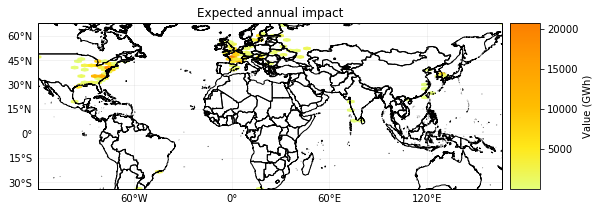

In [167]:
# impacts on nuclear power plants

imp_lf.plot_hexbin_eai_exposure(pop_name=False)

In [168]:
print(imp_lf.at_event[:1259].sum()) #2006-2030


1833902.1936207511


In [169]:
imp_lf.at_event[4538:].sum() #2075-2099


3928653.02659179

In [170]:
(lowflow.intensity>365).nnz/lowflow.intensity.nnz #only 1/1000 events last longer than a year

0.06711503992076966

In [172]:
test = np.where(lowflow.intensity.data>365)[0]
len(test)

53807

(array([11138.,  7282.,  4846.,  3498.,  2958.,  2267.,  1863.,  1448.,
         1300.,  1006.,   866.,   813.,   705.,   664.,   620.,   553.,
          539.,   526.,   479.,   417.,   390.,   362.,   285.,   293.,
          249.,   258.,   239.,   248.,   221.,   184.,   192.,   195.,
          185.,   194.,   181.,   169.,   157.,   177.,   147.,   145.,
          123.,   137.,   126.,   126.,   128.,   131.,   126.,   106.,
           92.,   106.,    97.,   117.,   102.,   107.,    96.,    99.,
           96.,   112.,    88.,    98.,    80.,    99.,    85.,    73.,
           85.,    77.,    94.,    74.,    69.,    69.,    74.,    62.,
           74.,    72.,    53.,    69.,    68.,    68.,    74.,    71.,
           61.,    73.,    82.,    74.,    72.,   100.,    84.,   107.,
           79.,    97.,    79.,    70.,    82.,    67.,    60.,    78.,
           82.,   100.,   118.,   280.]),
 array([  366.  ,   479.22,   592.44,   705.66,   818.88,   932.1 ,
         1045.32,  1158.54

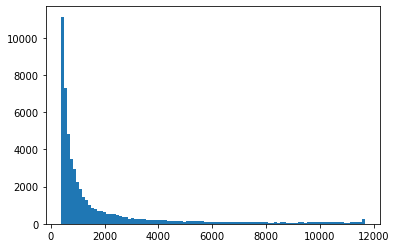

In [173]:
#distribution of the intensity of the events lasting more than a year

fig, ax = plt.subplots(1, 1)
ax.hist(np.array(lowflow.intensity[lowflow.intensity>365]).flatten(),bins=100)

## Getting rid of exposures far from rivers and to close to the coast

In [207]:
# this data is built ith different layers from quantiles of river size, the following files were
# needed to reach a sufficient level of detail
# https://www.bafg.de/GRDC/EN/Home/homepage_node.html

rivers1 = gpd.read_file('/home/zelie/Python_projects/low_flow/data/rivnets/mrb_rivnets_Q09_10.shp')
rivers2 = gpd.read_file('/home/zelie/Python_projects/low_flow/data/rivnets/mrb_rivnets_Q08_09.shp')
rivers3 = gpd.read_file('/home/zelie/Python_projects/low_flow/data/rivnets/mrb_rivnets_Q07_08.shp')
rivers4 = gpd.read_file('/home/zelie/Python_projects/low_flow/data/rivnets/mrb_rivnets_Q06_07.shp')


In [140]:
rivers1.head()

,RIVER_BASI,CONTINENT,OCEAN,SEA,AREA_CALC,Shape_Leng,MRBID,geometry
0,ATOUI,Africa,Atlantic Ocean,North Atlantic,27695.3,4.092204,1201,LINESTRING (-14.00208333333333 22.202083333332...
1,BANDAMA,Africa,Atlantic Ocean,Gulf of Guinea,99253.9,13.885620,1202,(LINESTRING (-4.827083333333519 5.947916666666...
2,BIA,Africa,Atlantic Ocean,Gulf of Guinea,10957.0,1.051965,1203,LINESTRING (-3.227083333333525 6.0187499999993...
3,CAVALLY,Africa,Atlantic Ocean,Gulf of Guinea,29622.7,3.372281,1204,LINESTRING (-7.943750000000165 6.2979166666660...
4,CESTOS (also NUON),Africa,Atlantic Ocean,North Atlantic,12785.1,1.435313,1205,LINESTRING (-8.839583333333422 6.0979166666660...


In [208]:
def min_distance(point, lines):
    return lines.distance(point).min()

n=1
for rivers in [rivers1,rivers2,rivers3,rivers4]:
    nuclear_exp["".join(['min_dist_to_lines',str(n)])] = nuclear_exp.geometry.apply(min_distance, args=(rivers,))
    n=n+1

nuclear_exp['min_dist_to_lines']=nuclear_exp.iloc[:,29:].min(axis=1)
nuclear_close_to_rivers = nuclear_exp[(nuclear_exp['min_dist_to_lines']<0.2)]


In [210]:
nuclear_close_to_rivers = nuclear_exp[(nuclear_exp['min_dist_to_lines']<0.2)]
nuclear_close_to_rivers = nuclear_close_to_rivers.drop(nuclear_close_to_rivers.columns[29:], axis=1)

In [214]:
nuclear_close_to_rivers = Exposures(nuclear_close_to_rivers)
nuclear_close_to_rivers.crs = {'init': 'epsg:4326'}
nuclear_close_to_rivers['dist_to_coast'] = dist_to_coast(nuclear_close_to_rivers) #get the distance to coast 
nuclear_close_to_rivers = nuclear_close_to_rivers[nuclear_close_to_rivers['dist_to_coast']>10000] # dist to coast is in meters

In [215]:
nuclear_close_to_rivers

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh,gen_mean,value,if_,if_LF,geometry,dist_to_coast
72,ARG,Argentina,ATUCHA I,ARG0000029,370.0,-33.9670,-59.2059,Nuclear,NaN,NaN,...,NaN,NaN,NaN,1208.009075,NaN,1208.009075,1,1,POINT (-59.2059 -33.967),6.629126e+04
73,ARG,Argentina,ATUCHA II,ARG0000030,745.0,-33.9674,-59.2045,Nuclear,NaN,NaN,...,NaN,NaN,NaN,2432.342598,NaN,2432.342598,1,1,POINT (-59.2045 -33.9674),6.618733e+04
197,ARG,Argentina,EMBALSE,ARG0000112,648.0,-32.2316,-64.4422,Nuclear,NaN,NaN,...,NaN,NaN,NaN,2115.648327,NaN,2115.648327,1,1,POINT (-64.4422 -32.2316),5.704915e+05
294,ARM,Armenia,Armenian-2,WRI1019028,375.0,40.1805,44.1498,Nuclear,NaN,NaN,...,NaN,NaN,NaN,2465.000000,NaN,2465.000000,1,1,POINT (44.1498 40.1805),2.654952e+05
978,BEL,Belgium,TIHANGE 1N,WRI1002275,962.0,50.5342,5.2751,Nuclear,NaN,NaN,...,6151.420,NaN,NaN,5471.377029,6151.420000,5811.398515,1,1,POINT (5.2751 50.5342),1.065003e+05
979,BEL,Belgium,TIHANGE 3,WRI1002277,2053.8,50.5342,5.2751,Nuclear,NaN,NaN,...,6995.774,NaN,NaN,11680.991832,6995.774000,9338.382916,1,1,POINT (5.2751 50.5342),1.065003e+05
3395,BGR,Bulgaria,KOZLODUY,WRI1008053,2000.0,43.7438,23.7723,Nuclear,NaN,NaN,...,NaN,NaN,NaN,15867.000000,NaN,15867.000000,1,1,POINT (23.7723 43.7438),3.150205e+05
3570,CAN,Canada,Bruce A,CAN0002030,3220.0,44.3391,-81.5747,Nuclear,NaN,NaN,...,NaN,NaN,NaN,24324.621861,NaN,24324.621861,1,1,POINT (-81.57470000000001 44.3391),5.491686e+05
3571,CAN,Canada,Bruce B,CAN0002031,3390.0,44.3190,-81.6027,Nuclear,NaN,NaN,...,NaN,NaN,NaN,25608.841027,NaN,25608.841027,1,1,POINT (-81.6027 44.319),5.517611e+05
3691,CAN,Canada,Darlington,CAN0002043,3740.0,43.8697,-78.7239,Nuclear,NaN,NaN,...,NaN,NaN,NaN,28252.821664,NaN,28252.821664,1,1,POINT (-78.7239 43.8697),3.434606e+05


In [216]:
len(nuclear_close_to_rivers)/len(nuclear_exp)

0.5505050505050505

(35, 65)

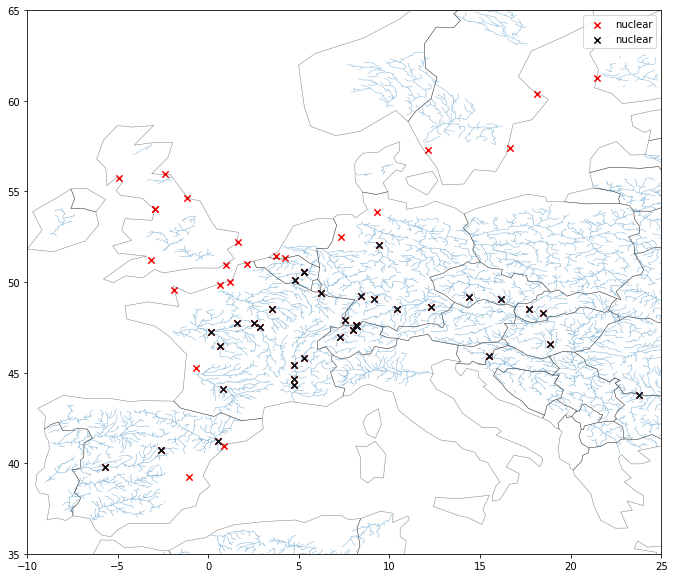

In [217]:
#ax,fig = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
nuclear_exp.plot(ax=ax,color='Red',markersize=40,label='nuclear',marker='x')
nuclear_close_to_rivers.plot(ax=ax,markersize=40,label='nuclear',marker='x',color='Black')

ax.legend()
ax.set_xlim(-10, 25)
ax.set_ylim(35, 65)

(20, 50)

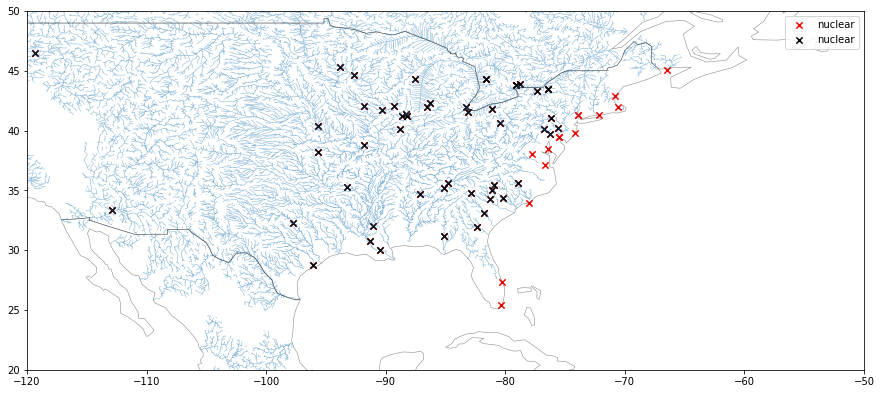

In [218]:
#ax,fig = plt.subplots()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = rivers1.plot(figsize=(15,10), linewidth=0.5,alpha=0.5)
world.boundary.plot(ax=ax,color='Black', linewidth=0.5,alpha=0.5)
rivers2.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers3.plot(linewidth=0.5,ax=ax,alpha=0.5)
rivers4.plot(linewidth=0.5,ax=ax,alpha=0.5)
#coal_close_to_rivers.plot(ax=ax,color='Black',markersize=5,label='coal')
#gas_close_to_rivers.plot(ax=ax,color='Blue',markersize=5, label='gas')
#hydro_close_to_rivers.plot(ax=ax,color='Green',markersize=5,label='hydro')
nuclear_exp.plot(ax=ax,color='Red',markersize=40,label='nuclear',marker='x')
nuclear_close_to_rivers.plot(ax=ax,markersize=40,label='nuclear',marker='x',color='Black')

ax.legend()
ax.set_xlim(-120, -50)
ax.set_ylim(20, 50)

